In [43]:
from typing_extensions import Literal
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.graph import MessagesState, StateGraph,START,END
from langgraph.types import Command
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from IPython.display import Image, display
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools import DuckDuckGoSearchRun
import os

In [44]:
load_dotenv()
gemini_api_key = os.getenv("GEMINI_API_KEY")

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash",api_key=gemini_api_key)

In [45]:
search_tool = DuckDuckGoSearchRun()
search_tool.invoke("what is virat kohli?")

'Virat Kohli Virat Kohli (b. 1988) is an Indian international cricketer and a former captain of the Indian cricket team in all three international formats. Kohli plays for (and previously captained) the Royal Challengers Bangalore (RCB) in the Indian Premier League (IPL). Kohli is considered by many as one of the greatest batsmen in the history of the game. He is also one of the most successful captains ... Virat Kohli \'s senior career began when he made his debut in List A cricket, playing against Services in the Ranji One-Day Trophy, but he did not have the opportunity to bat during the match. [1] On the international stage, he has been representing India since he was included in the ODl squad for the tour of Sri Lanka. Kohli in 2020 Kohli was part of the team during India won the 2011 Cricket ... Why Is Virat Kohli So Famous? His fame stems from his exceptional cricketing skills, holding records like the most centuries in ODI cricket. Check out the Virat Kohli complete profile, ICC

In [46]:
repl = PythonREPL()

In [47]:
code = """
x=5
y=x*2
print(y)
"""

In [48]:
repl.run(code)

'10\n'

In [49]:
@tool
def python_repl_tool(
    code: Annotated[str,"The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return(
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

<>:11: SyntaxWarning: invalid escape sequence '\`'
<>:11: SyntaxWarning: invalid escape sequence '\`'
<>:11: SyntaxWarning: invalid escape sequence '\`'
<>:11: SyntaxWarning: invalid escape sequence '\`'
C:\Users\Parth\AppData\Local\Temp\ipykernel_23596\2402313455.py:11: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
C:\Users\Parth\AppData\Local\Temp\ipykernel_23596\2402313455.py:11: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


In [50]:
def make_system_prompt(instruction: str)->str:
    return (
        "You are a helpful AI assistant collaborating with other specialized assistants to solve complex tasks.\n\n"
        "Your role is to:\n"
        "- Use the provided tools and context to make meaningful progress toward answering the user's question.\n"
        "- If you are unable to complete the task fully, provide a partial answer or progress update so another assistant can continue from where you left off.\n"
        "- If a tool such as Matplotlib is available, and a graph or visual can help, include it in your response.\n"
        "- If you or any assistant has arrived at a complete and final answer or deliverable, prefix your response with: FINAL ANSWER\n\n"
        "Always explain your reasoning when helpful. If tool use is needed, call the appropriate tool or request human input if necessary.\n\n"
    )

In [51]:
def get_next_node(last_message: BaseMessage,goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

In [52]:
research_agent = create_react_agent(
    llm,
    tools = [search_tool],
    prompt = make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)

In [53]:
chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
)

In [54]:
def research_node(state: MessagesState) -> Command[Literal["chart_generator",END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1],"chart_generator")
    result["messages"][-1]=HumanMessage(content=result["messages"][-1].content, name="researcher")
    return Command(update={"messages": result["messages"]},goto=goto)

In [55]:
def chart_node(state: MessagesState) -> Command[Literal["researcher",END]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1],"researcher")
    result["messages"][-1]=HumanMessage(content=result["messages"][-1].content, name="chart_generator")
    return Command(update={"messages": result["messages"]},goto=goto)

In [56]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher",research_node)
workflow.add_node("chart_generator",chart_node)

workflow.add_edge(START,"researcher")
app = workflow.compile()

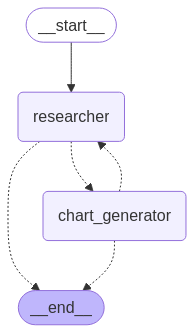

In [60]:
display(Image(app.get_graph().draw_mermaid_png()))

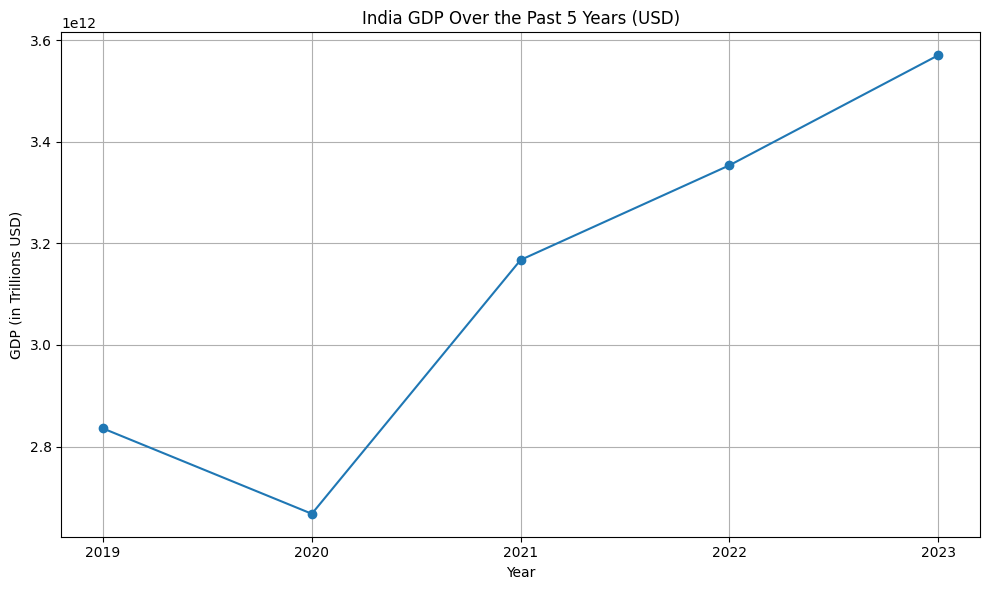

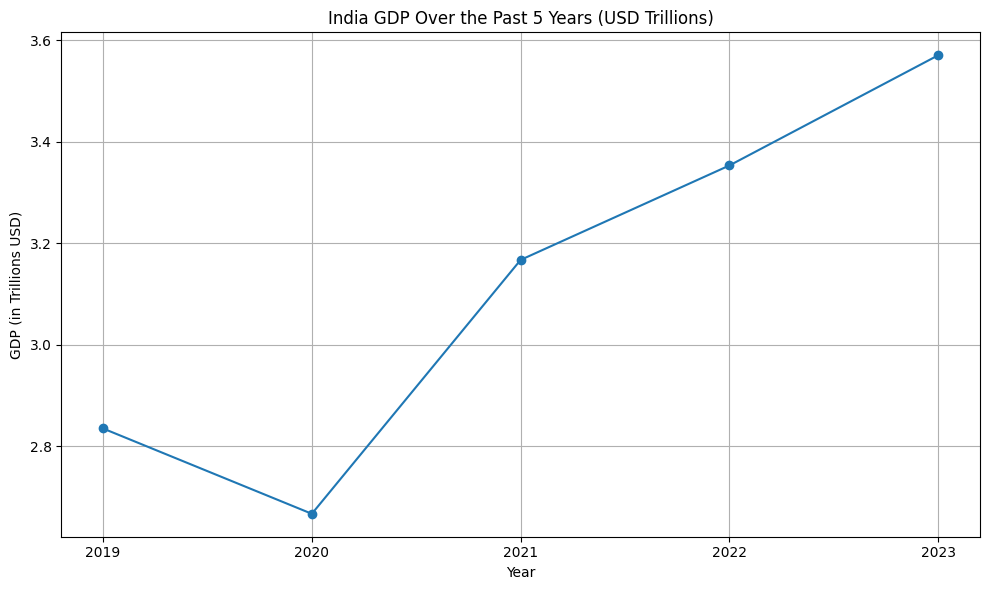

{'messages': [HumanMessage(content="get the india's GDP over the past 5 years, then make a line chart of it.Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='da9416f4-c39c-468b-a56f-4d00f69394c0'),
  AIMessage(content="I can search for India's GDP over the past 5 years, but I can't create a line chart directly. After I get the data, I'll provide it to you so you can create the chart using a tool like Matplotlib.", additional_kwargs={'function_call': {'name': 'duckduckgo_search', 'arguments': '{"query": "India GDP past 5 years"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-962921d4-2f3d-4324-af61-eba66c0ecf5c-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'India GDP past 5 years'}, 'id': '0eafdeb5-95a1-46af-9f9b-82f016f5f034', 'type': 'tool_call'}], usage_metadata={'input_tokens': 218, 'output_tokens': 65, 'total_tokens': 283, 'input_token_det

In [ ]:
app.invoke({"messages": [("user","get the india's GDP over the past 5 years, then make a line chart of it.Once you make the chart, finish.")],})